In [2]:
# Load the dataset from the uploaded file
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, GRU
from tensorflow.keras.optimizers import SGD  # Import SGD optimizer
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the dataset into a dataframe
file_path = '/content/drive/MyDrive/Assignment 3/data/GOOG.csv'
data = pd.read_csv(file_path)

# Create a new dataframe by removing the 'Adjusted Close' column
data_without_adjusted_close = data.drop(columns=['Adjusted Close'], errors='ignore')

In [5]:
# Check if there are any rows where 'Close' is greater than 'High'
invalid_close_high_rows = data_without_adjusted_close[data_without_adjusted_close['Close'] > data_without_adjusted_close['High']]

In [6]:
print("Rows where 'Close' is greater than 'High':")
print(invalid_close_high_rows)

Rows where 'Close' is greater than 'High':
Empty DataFrame
Columns: [Date, Low, Open, Volume, High, Close]
Index: []


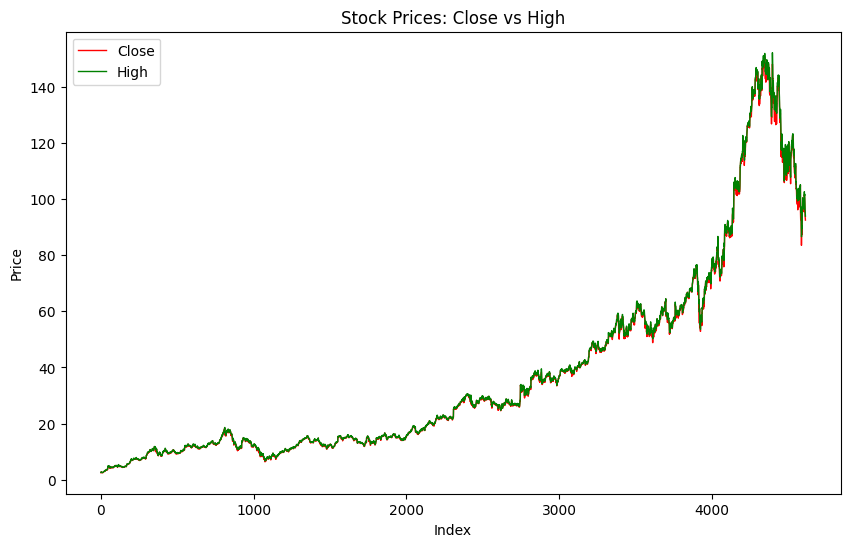

In [7]:
import matplotlib.pyplot as plt

# Plot 'Close' and 'High' values
plt.figure(figsize=(10, 6))
plt.plot(data_without_adjusted_close['Close'], label='Close', color='red', linewidth=1)
plt.plot(data_without_adjusted_close['High'], label='High', color='green', linewidth=1)

# Add title and labels
plt.title("Stock Prices: Close vs High")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()

# Display the plot
plt.show()


In [8]:
data_without_adjusted_close.head()

,Date,Low,Open,Volume,High,Close
0,19-08-2004,2.390042,2.490664,897427216,2.591785,2.499133
1,20-08-2004,2.503118,2.515820,458857488,2.716817,2.697639
2,23-08-2004,2.716070,2.758411,366857939,2.826406,2.724787
3,24-08-2004,2.579581,2.770615,306396159,2.779581,2.611960
4,25-08-2004,2.587302,2.614201,184645512,2.689918,2.640104


In [9]:
data_without_adjusted_close.describe()

,Low,Open,Volume,High,Close
count,4612.000000,4612.000000,4.612000e+03,4612.000000,4612.000000
mean,37.088474,37.471847,1.238896e+08,37.856624,37.477273
std,34.791176,35.163155,1.536223e+08,35.549294,35.170034
min,2.390042,2.470490,1.584340e+05,2.534002,2.490913
25%,12.401765,12.575302,2.992850e+07,12.697718,12.576174
50%,22.808758,22.980115,6.869051e+07,23.098795,22.954461
75%,52.975875,53.578501,1.549155e+08,54.106961,53.534375
max,149.887497,151.863495,1.650833e+09,152.100006,150.709000


In [10]:
print(f"The entire data set length: {len(data_without_adjusted_close)}")

The entire data set length: 4612


In [11]:
# Parse the 'Date' column as datetime and set it as the index
data_without_adjusted_close['Date'] = pd.to_datetime(data_without_adjusted_close['Date'])
data_with_date_index = data_without_adjusted_close.set_index('Date')

# Define split proportions
train_size = 0.7  # 70% training
validation_size = 0.15  # 15% validation
test_size = 0.15  # 15% testing

# Get split indices
n = len(data_with_date_index)
train_end = int(train_size * n)
validation_end = int((train_size + validation_size) * n)

# Perform the splits
train_data = data_with_date_index.iloc[:train_end]
validation_data = data_with_date_index.iloc[train_end:validation_end]
test_data = data_with_date_index.iloc[validation_end:]

# Print sizes of the datasets after splitting
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(validation_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 3228
Validation set size: 692
Test set size: 692


<ipython-input-11-4c1626899f94>:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data_without_adjusted_close['Date'] = pd.to_datetime(data_without_adjusted_close['Date'])


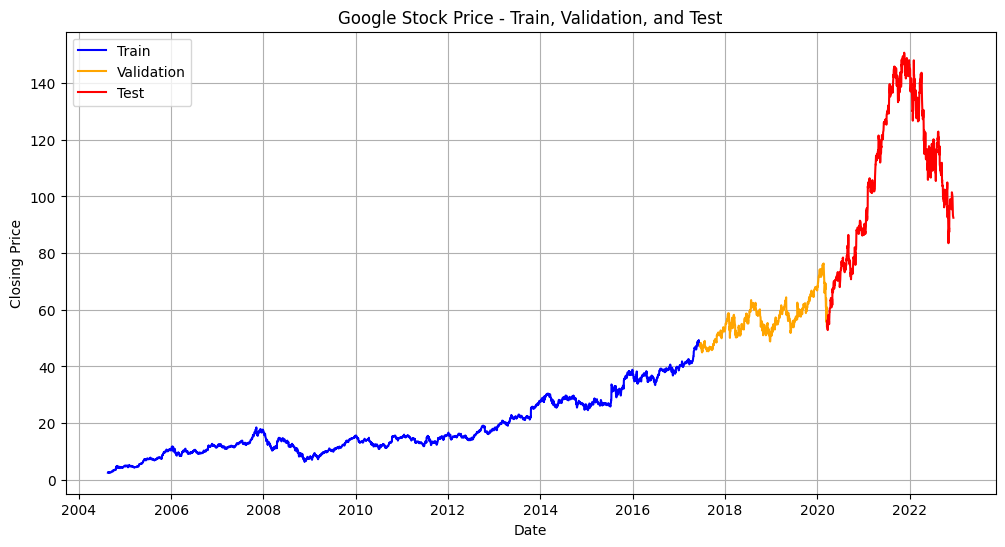

In [12]:
# Show the split dataset proportions
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Close'], label='Train', color='blue')
plt.plot(validation_data.index, validation_data['Close'], label='Validation', color='orange')
plt.plot(test_data.index, test_data['Close'], label='Test', color='red')

# Adding labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Google Stock Price - Train, Validation, and Test')
plt.legend()
plt.grid()

# Show the plot
plt.show()


In [13]:
# Separate predictors (X) and response variable (y) for each split
X_train = train_data.drop(columns=['Close'])
y_train = train_data['Close'].values.reshape(-1, 1)

X_val = validation_data.drop(columns=['Close'])
y_val = validation_data['Close'].values.reshape(-1, 1)

X_test = test_data.drop(columns=['Close'])
y_test = test_data['Close'].values.reshape(-1, 1)

# Print sizes of the splits for verification
print(f"Training set - Predictors (X_train): {X_train.shape}, Response (y_train): {y_train.shape}")
print(f"Validation set - Predictors (X_val): {X_val.shape}, Response (y_val): {y_val.shape}")
print(f"Test set - Predictors (X_test): {X_test.shape}, Response (y_test): {y_test.shape}")

Training set - Predictors (X_train): (3228, 4), Response (y_train): (3228, 1)
Validation set - Predictors (X_val): (692, 4), Response (y_val): (692, 1)
Test set - Predictors (X_test): (692, 4), Response (y_test): (692, 1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Initialize scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize each split separately
train_normalized = scaler.fit_transform(train_data)
validation_normalized = scaler.transform(validation_data)
test_normalized = scaler.transform(test_data)

# Sequence generation function
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length][4]  
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets).reshape(-1, 1)

# Sequence length
sequence_length = 50

# Generate sequences for each split
X_train, y_train = create_sequences(train_normalized, sequence_length)
X_val, y_val = create_sequences(validation_normalized, sequence_length)
X_test, y_test = create_sequences(test_normalized, sequence_length)

# Print shapes for verification
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (3178, 50, 5), y_train shape: (3178, 1)
X_val shape: (642, 50, 5), y_val shape: (642, 1)
X_test shape: (642, 50, 5), y_test shape: (642, 1)


### Vanilla RNN

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0039 - mae: 0.0420 - val_loss: 0.0021 - val_mae: 0.0388
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.6763e-04 - mae: 0.0118 - val_loss: 0.0017 - val_mae: 0.0356
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3431e-04 - mae: 0.0082 - val_loss: 0.0011 - val_mae: 0.0271
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.7368e-05 - mae: 0.0068 - val_loss: 7.2708e-04 - val_mae: 0.0193
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.4108e-05 - mae: 0.0074 - val_loss: 7.2281e-04 - val_mae: 0.0197
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.4176e-05 - mae: 0.0067 - val_loss: 6.7720e-04 - val_mae: 0.0187
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 8.0519e-05 - mae: 0.0066 - val_loss: 7.2596e-04 - val_mae: 0.0198
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 9.0311e-05 - mae: 0.0065 - val_loss: 7.4473e-04 - val_mae: 0.0196
Epoc

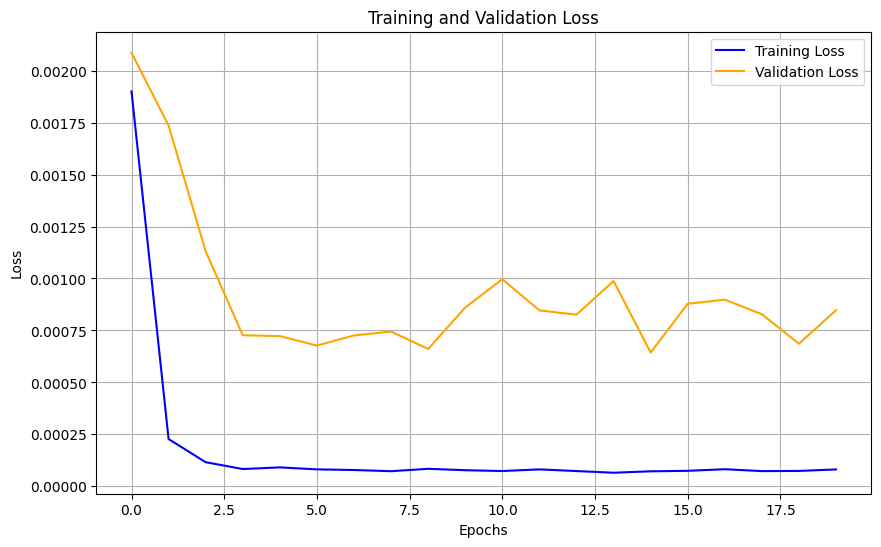

In [ ]:
class VanillaRNNModel:
    def __init__(self, input_shape):
        self.model = Sequential([
            SimpleRNN(32, activation='tanh', input_shape=input_shape),
            Dense(1) 
        ])

    def compile(self):
        self.model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    def train(self, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )

    def plot_loss(self):
        history = self.history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss', color='blue')
        plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.show()

rnn_model = VanillaRNNModel(input_shape=(X_train.shape[1], X_train.shape[2]))
rnn_model.compile()
rnn_model.train(X_train, y_train, X_val, y_val, epochs=20, batch_size=32)

rnn_model.plot_loss()


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Vanilla RNN Validation Metrics (Original Scale):
Mean Absolute Error (MAE): 1.0094122485579735
Mean Squared Error (MSE): 1.8478375767952697
Root Mean Squared Error (RMSE): 1.3593518958662874
R-squared (R2): 0.9517529540070191


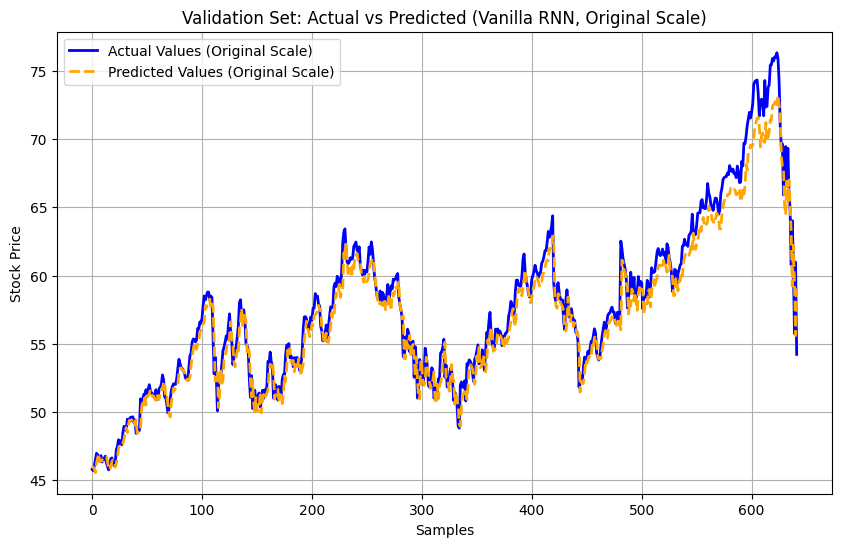

In [ ]:
y_val_pred_rnn = rnn_model.model.predict(X_val)

y_val_reshaped = y_val.reshape(-1, 1)  
y_val_pred_rnn_reshaped = y_val_pred_rnn.reshape(-1, 1)

# Perform inverse transformation on just the Close column
y_val_inv = scaler.inverse_transform(np.hstack([np.zeros_like(y_val_reshaped)] * (train_data.shape[1] - 1) + [y_val_reshaped]))[:, -1]
y_val_pred_rnn_inv = scaler.inverse_transform(np.hstack([np.zeros_like(y_val_pred_rnn_reshaped)] * (train_data.shape[1] - 1) + [y_val_pred_rnn_reshaped]))[:, -1]

mae = mean_absolute_error(y_val_inv, y_val_pred_rnn_inv)
mse = mean_squared_error(y_val_inv, y_val_pred_rnn_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_inv, y_val_pred_rnn_inv)

# Print metrics
print(f"Vanilla RNN Validation Metrics (Original Scale):")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

# Plot Predicted vs Actual Values (Original Scale)
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv, label='Actual Values (Original Scale)', color='blue', linewidth=2)
plt.plot(y_val_pred_rnn_inv, label='Predicted Values (Original Scale)', color='orange', linewidth=2, linestyle='dashed')
plt.title('Validation Set: Actual vs Predicted (Vanilla RNN, Original Scale)')
plt.xlabel('Samples')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()


### LSTM

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0268 - mae: 0.0968 - val_loss: 0.0095 - val_mae: 0.0798
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.3934e-04 - mae: 0.0116 - val_loss: 0.0104 - val_mae: 0.0854
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1950e-04 - mae: 0.0109 - val_loss: 0.0094 - val_mae: 0.0812
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1964e-04 - mae: 0.0104 - val_loss: 0.0096 - val_mae: 0.0842
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.1262e-04 - mae: 0.0106 - val_loss: 0.0058 - val_mae: 0.0615
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8458e-04 - mae: 0.0098 - val_loss: 0.0051 - val_mae: 0.0576
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0231e-04 - mae: 0.0098 - val_loss: 0.0037 - val_mae: 0.0476
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6689e-04 - mae: 0.0094 - val_loss: 0.0029 - val_mae: 0.0412
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━

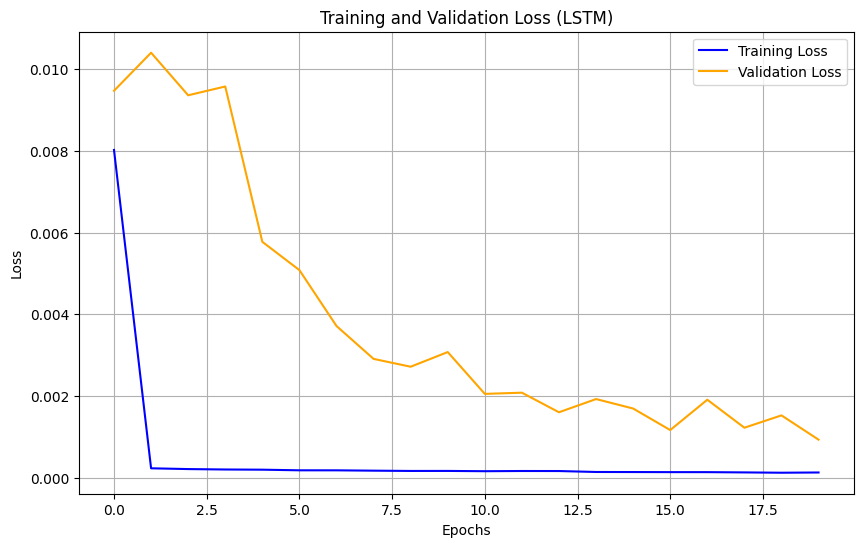

In [ ]:
class LSTMModel:
    def __init__(self, input_shape):
        # Initialize the LSTM model
        self.model = Sequential([
            LSTM(32, activation='tanh', input_shape=input_shape, return_sequences=False),
            Dense(1) 
        ])

    def compile(self):
        self.model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    def train(self, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )

    def plot_loss(self):
        history = self.history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss', color='blue')
        plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
        plt.title('Training and Validation Loss (LSTM)')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.show()

lstm_model = LSTMModel(input_shape=(X_train.shape[1], X_train.shape[2]))
lstm_model.compile()
lstm_model.train(X_train, y_train, X_val, y_val, epochs=20, batch_size=32)

lstm_model.plot_loss()


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
LSTM Validation Metrics (Original Scale):
Mean Absolute Error (MAE): 1.031833500134239
Mean Squared Error (MSE): 2.030019373311986
Root Mean Squared Error (RMSE): 1.4247874835609646
R-squared (R2): 0.9469961866233457


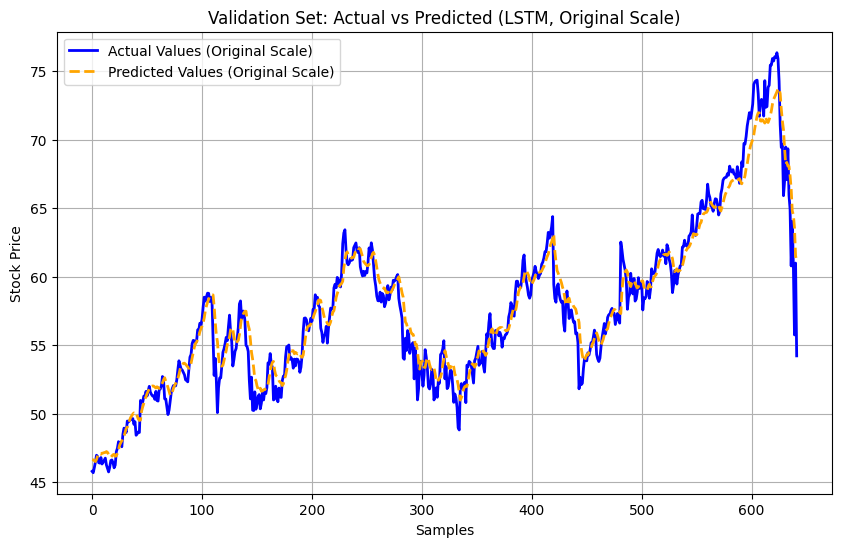

In [ ]:
y_val_pred_lstm = lstm_model.model.predict(X_val)

y_val_reshaped = y_val.reshape(-1, 1)  
y_val_pred_lstm_reshaped = y_val_pred_lstm.reshape(-1, 1)

# Perform inverse transformation on just the Close column
y_val_inv = scaler.inverse_transform(np.hstack([np.zeros_like(y_val_reshaped)] * (train_data.shape[1] - 1) + [y_val_reshaped]))[:, -1]
y_val_pred_lstm_inv = scaler.inverse_transform(np.hstack([np.zeros_like(y_val_pred_lstm_reshaped)] * (train_data.shape[1] - 1) + [y_val_pred_lstm_reshaped]))[:, -1]

mae = mean_absolute_error(y_val_inv, y_val_pred_lstm_inv)
mse = mean_squared_error(y_val_inv, y_val_pred_lstm_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_inv, y_val_pred_lstm_inv)

# Print metrics
print(f"LSTM Validation Metrics (Original Scale):")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

# Plot Predicted vs Actual Values (Original Scale)
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv, label='Actual Values (Original Scale)', color='blue', linewidth=2)
plt.plot(y_val_pred_lstm_inv, label='Predicted Values (Original Scale)', color='orange', linewidth=2, linestyle='dashed')
plt.title('Validation Set: Actual vs Predicted (LSTM, Original Scale)')
plt.xlabel('Samples')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()


### GRU

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0928 - mae: 0.1924 - val_loss: 0.0179 - val_mae: 0.1212
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7752e-04 - mae: 0.0125 - val_loss: 0.0119 - val_mae: 0.0962
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.5738e-04 - mae: 0.0092 - val_loss: 0.0089 - val_mae: 0.0809
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1080e-04 - mae: 0.0077 - val_loss: 0.0064 - val_mae: 0.0659
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1090e-04 - mae: 0.0076 - val_loss: 0.0065 - val_mae: 0.0679
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0516e-04 - mae: 0.0072 - val_loss: 0.0061 - val_mae: 0.0653
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.8688e-05 - mae: 0.0067 - val_loss: 0.0052 - val_mae: 0.0591
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.9742e-05 - mae: 0.0064 - val_loss: 0.0061 - val_mae: 0.0663
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━

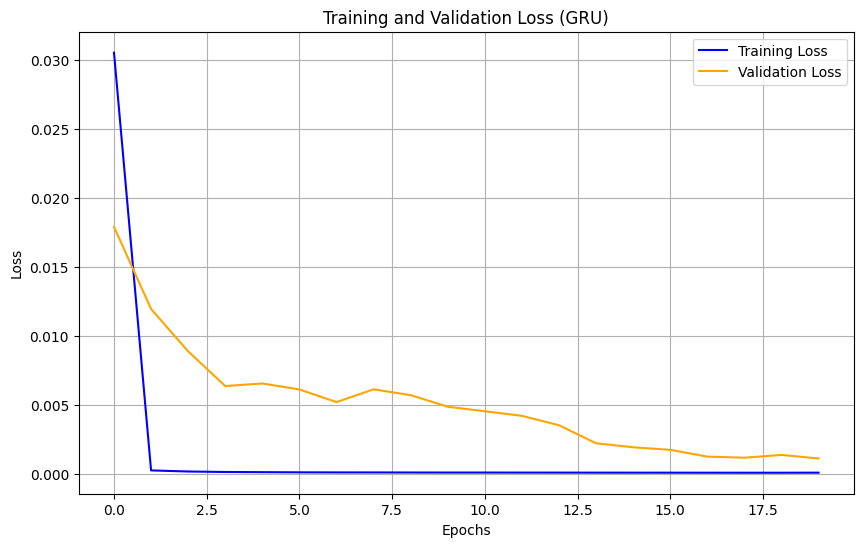

In [ ]:
class GRUModel:
    def __init__(self, input_shape):
        self.model = Sequential([
            GRU(32, activation='tanh', input_shape=input_shape, return_sequences=False),
            Dense(1) 
        ])

    def compile(self):
        self.model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    def train(self, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )

    def plot_loss(self):
        history = self.history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss', color='blue')
        plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
        plt.title('Training and Validation Loss (GRU)')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.show()

gru_model = GRUModel(input_shape=(X_train.shape[1], X_train.shape[2]))
gru_model.compile()
gru_model.train(X_train, y_train, X_val, y_val, epochs=20, batch_size=32)

gru_model.plot_loss()


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
GRU Validation Metrics (Original Scale):
Mean Absolute Error (MAE): 1.1514210210782347
Mean Squared Error (MSE): 2.395877114291087
Root Mean Squared Error (RMSE): 1.5478621108778026
R-squared (R2): 0.9374436396475883


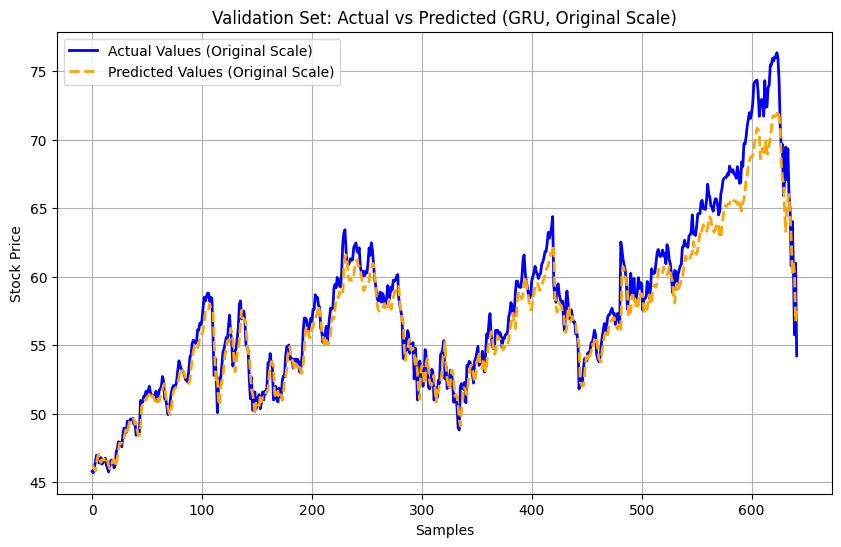

In [ ]:
y_val_pred_gru = gru_model.model.predict(X_val)

y_val_reshaped = y_val.reshape(-1, 1) 
y_val_pred_gru_reshaped = y_val_pred_gru.reshape(-1, 1)

# Perform inverse transformation on just the Close column
y_val_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_val_reshaped)] * (train_data.shape[1] - 1) + [y_val_reshaped])
)[:, -1]
y_val_pred_gru_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_val_pred_gru_reshaped)] * (train_data.shape[1] - 1) + [y_val_pred_gru_reshaped])
)[:, -1]

mae = mean_absolute_error(y_val_inv, y_val_pred_gru_inv)
mse = mean_squared_error(y_val_inv, y_val_pred_gru_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_inv, y_val_pred_gru_inv)

# Print metrics
print(f"GRU Validation Metrics (Original Scale):")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

# Plot Predicted vs Actual Values (Original Scale)
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv, label='Actual Values (Original Scale)', color='blue', linewidth=2)
plt.plot(y_val_pred_gru_inv, label='Predicted Values (Original Scale)', color='orange', linewidth=2, linestyle='dashed')
plt.title('Validation Set: Actual vs Predicted (GRU, Original Scale)')
plt.xlabel('Samples')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()


## Experimental analysis with exploring different hyperparameters


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0095 - mae: 0.0643 - val_loss: 0.0228 - val_mae: 0.1235
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.9710e-04 - mae: 0.0128 - val_loss: 0.0150 - val_mae: 0.0985
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7575e-04 - mae: 0.0099 - val_loss: 0.0092 - val_mae: 0.0717
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4713e-04 - mae: 0.0092 - val_loss: 0.0059 - val_mae: 0.0544
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0299e-04 - mae: 0.0075 - val_loss: 0.0046 - val_mae: 0.0472
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.2007e-04 - mae: 0.0083 - val_loss: 0.0063 - val_mae: 0.0607
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0566e-04 - mae: 0.0076 - val_loss: 0.0039 - val_mae: 0.0445
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0594e-04 - mae: 0.0077 - val_loss: 0.0048 - val_mae: 0.0532
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━

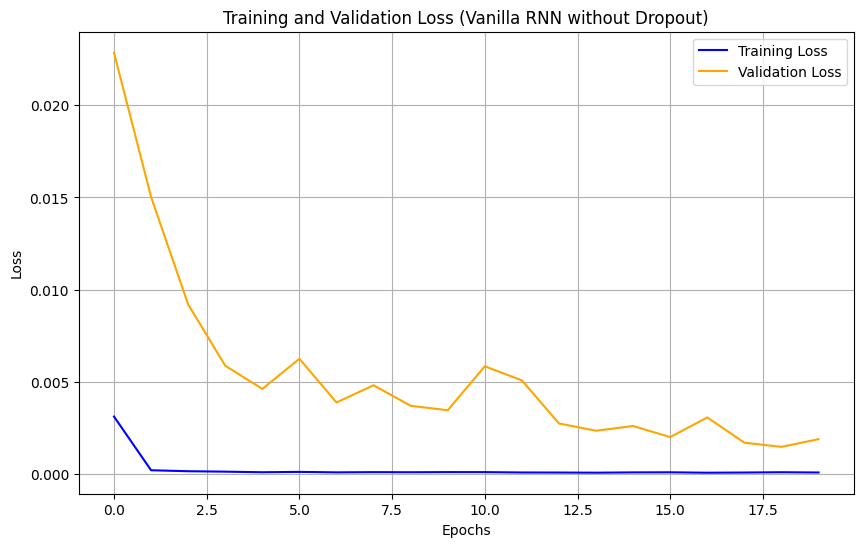

In [ ]:
class VanillaRNNHyperTuned:
    def __init__(self, input_shape, units=64, activation='tanh', learning_rate=0.001):
        self.model = Sequential([
            SimpleRNN(units, activation=activation, input_shape=input_shape),
            Dense(1) 
        ])
        self.learning_rate = learning_rate

    def compile(self):
        optimizer = Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    def train(self, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )

    def plot_loss(self):
        history = self.history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss', color='blue')
        plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
        plt.title('Training and Validation Loss (Vanilla RNN without Dropout)')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.show()

units = 64  
activation = 'tanh'  
learning_rate = 0.001  
batch_size = 32  
epochs = 20  


vanilla_rnn_hypertuned = VanillaRNNHyperTuned(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    units=units,
    activation=activation,
    learning_rate=learning_rate
)
vanilla_rnn_hypertuned.compile()
vanilla_rnn_hypertuned.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)


vanilla_rnn_hypertuned.plot_loss()


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Tuned Vanilla RNN Validation Metrics (Original Scale):
Mean Absolute Error (MAE): 1.4857597885844864
Mean Squared Error (MSE): 4.147924701965309
Root Mean Squared Error (RMSE): 2.036645453181606
R-squared (R2): 0.8916976706263213


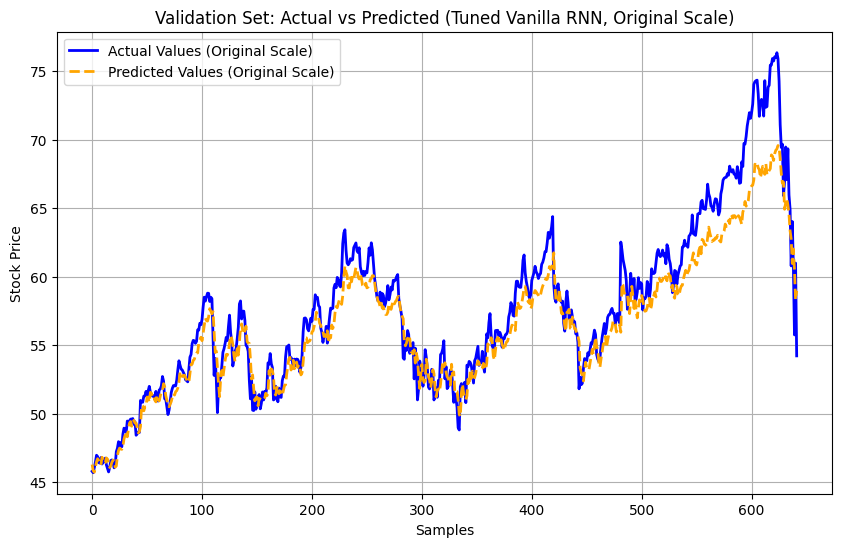

In [ ]:
y_val_pred_tuned_rnn = vanilla_rnn_hypertuned.model.predict(X_val)


y_val_reshaped = y_val.reshape(-1, 1) 
y_val_pred_tuned_rnn_reshaped = y_val_pred_tuned_rnn.reshape(-1, 1)

# Perform inverse transformation on just the Close column
y_val_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_val_reshaped)] * (train_data.shape[1] - 1) + [y_val_reshaped])
)[:, -1]
y_val_pred_tuned_rnn_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_val_pred_tuned_rnn_reshaped)] * (train_data.shape[1] - 1) + [y_val_pred_tuned_rnn_reshaped])
)[:, -1]

mae = mean_absolute_error(y_val_inv, y_val_pred_tuned_rnn_inv)
mse = mean_squared_error(y_val_inv, y_val_pred_tuned_rnn_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_inv, y_val_pred_tuned_rnn_inv)

# Print metrics
print(f"Tuned Vanilla RNN Validation Metrics (Original Scale):")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

# Plot Predicted vs Actual Values (Original Scale)
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv, label='Actual Values (Original Scale)', color='blue', linewidth=2)
plt.plot(y_val_pred_tuned_rnn_inv, label='Predicted Values (Original Scale)', color='orange', linewidth=2, linestyle='dashed')
plt.title('Validation Set: Actual vs Predicted (Tuned Vanilla RNN, Original Scale)')
plt.xlabel('Samples')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0113 - mae: 0.0624 - val_loss: 0.0088 - val_mae: 0.0809
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8602e-04 - mae: 0.0101 - val_loss: 0.0026 - val_mae: 0.0393
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8993e-04 - mae: 0.0097 - val_loss: 0.0025 - val_mae: 0.0398
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6541e-04 - mae: 0.0091 - val_loss: 0.0014 - val_mae: 0.0269
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7511e-04 - mae: 0.0092 - val_loss: 0.0013 - val_mae: 0.0276
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4986e-04 - mae: 0.0087 - val_loss: 0.0015 - val_mae: 0.0316
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4528e-04 - mae: 0.0088 - val_loss: 0.0012 - val_mae: 0.0271
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4978e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0254
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━

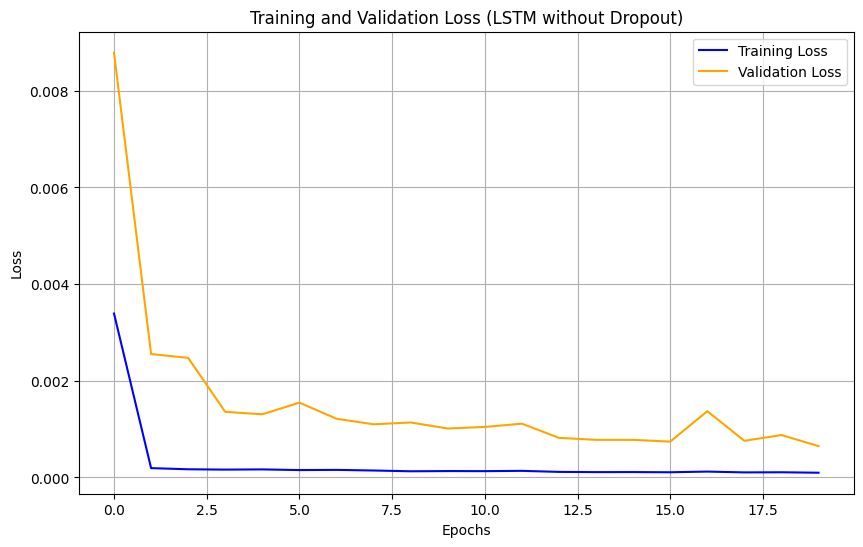

In [ ]:

class LSTM_hypertuned:
    def __init__(self, input_shape, units=64, activation='tanh', learning_rate=0.001):
        
        self.model = Sequential([
            tf.keras.layers.LSTM(units, activation=activation, input_shape=input_shape),
            Dense(1)  
        ])
        self.learning_rate = learning_rate

    def compile(self):
        
        optimizer = Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    def train(self, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
        
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )

    def plot_loss(self):
        
        history = self.history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss', color='blue')
        plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
        plt.title('Training and Validation Loss (LSTM without Dropout)')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.show()


units = 64  
activation = 'tanh'  
learning_rate = 0.001  
batch_size = 32  
epochs = 20  


lstm_hypertuned = LSTM_hypertuned(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    units=units,
    activation=activation,
    learning_rate=learning_rate
)
lstm_hypertuned.compile()
lstm_hypertuned.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)


lstm_hypertuned.plot_loss()


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Tuned LSTM Validation Metrics (Original Scale):
Mean Absolute Error (MAE): 0.867073623562156
Mean Squared Error (MSE): 1.4151000324351777
Root Mean Squared Error (RMSE): 1.1895797713626344
R-squared (R2): 0.9630517328974455


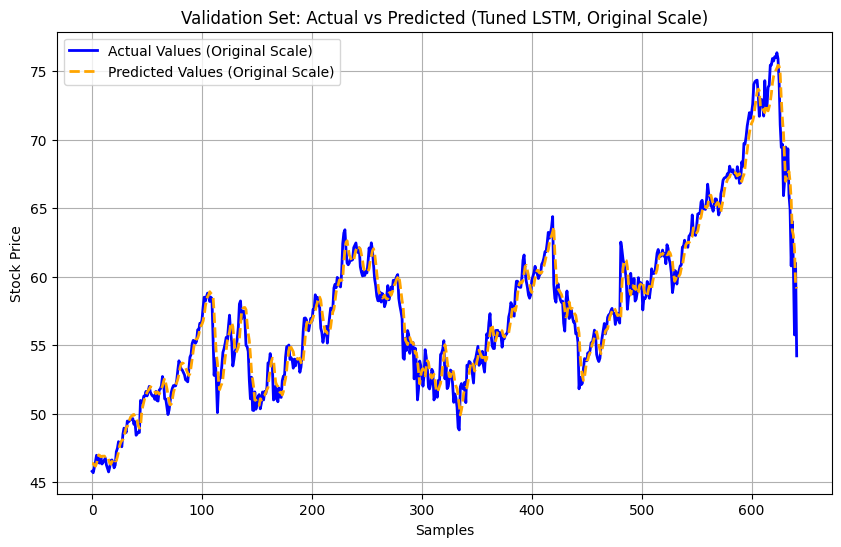

In [ ]:
y_val_pred_tuned_lstm = lstm_hypertuned.model.predict(X_val)

y_val_reshaped = y_val.reshape(-1, 1)  
y_val_pred_tuned_lstm_reshaped = y_val_pred_tuned_lstm.reshape(-1, 1)

# Perform inverse transformation on just the Close column
y_val_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_val_reshaped)] * (train_data.shape[1] - 1) + [y_val_reshaped])
)[:, -1]
y_val_pred_tuned_lstm_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_val_pred_tuned_lstm_reshaped)] * (train_data.shape[1] - 1) + [y_val_pred_tuned_lstm_reshaped])
)[:, -1]

mae = mean_absolute_error(y_val_inv, y_val_pred_tuned_lstm_inv)
mse = mean_squared_error(y_val_inv, y_val_pred_tuned_lstm_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_inv, y_val_pred_tuned_lstm_inv)

# Print metrics
print(f"Tuned LSTM Validation Metrics (Original Scale):")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

# Plot Predicted vs Actual Values (Original Scale)
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv, label='Actual Values (Original Scale)', color='blue', linewidth=2)
plt.plot(y_val_pred_tuned_lstm_inv, label='Predicted Values (Original Scale)', color='orange', linewidth=2, linestyle='dashed')
plt.title('Validation Set: Actual vs Predicted (Tuned LSTM, Original Scale)')
plt.xlabel('Samples')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0647 - mae: 0.1554 - val_loss: 0.0044 - val_mae: 0.0586
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2140e-04 - mae: 0.0111 - val_loss: 0.0021 - val_mae: 0.0383
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2432e-04 - mae: 0.0080 - val_loss: 0.0017 - val_mae: 0.0344
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.6354e-05 - mae: 0.0071 - val_loss: 0.0011 - val_mae: 0.0270
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.1144e-05 - mae: 0.0062 - val_loss: 7.3578e-04 - val_mae: 0.0208
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.2444e-05 - mae: 0.0063 - val_loss: 9.2555e-04 - val_mae: 0.0243
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.0137e-05 - mae: 0.0064 - val_loss: 8.1050e-04 - val_mae: 0.0224
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.6017e-05 - mae: 0.0058 - val_loss: 6.1890e-04 - val_mae: 0.0187
Epoch 9/20
100/100 ━━━━

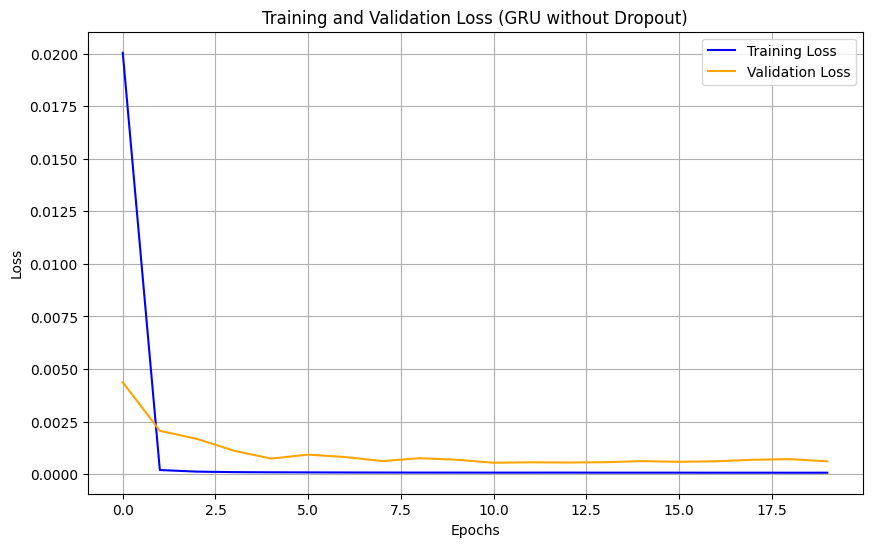

In [ ]:

class GRU_hypertuned:
    def __init__(self, input_shape, units=64, activation='tanh', learning_rate=0.001):
        
        self.model = Sequential([
            tf.keras.layers.GRU(units, activation=activation, input_shape=input_shape),
            Dense(1)  
        ])
        self.learning_rate = learning_rate

    def compile(self):
        
        optimizer = Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    def train(self, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
        
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )

    def plot_loss(self):
        
        history = self.history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss', color='blue')
        plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
        plt.title('Training and Validation Loss (GRU without Dropout)')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.show()


units = 64  
activation = 'tanh'  
learning_rate = 0.001  
batch_size = 32  
epochs = 20  


gru_hypertuned = GRU_hypertuned(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    units=units,
    activation=activation,
    learning_rate=learning_rate
)
gru_hypertuned.compile()
gru_hypertuned.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)


gru_hypertuned.plot_loss()


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Tuned GRU Validation Metrics (Original Scale):
Mean Absolute Error (MAE): 0.858422240735586
Mean Squared Error (MSE): 1.3219947373862433
Root Mean Squared Error (RMSE): 1.1497802996165152
R-squared (R2): 0.9654827124969656


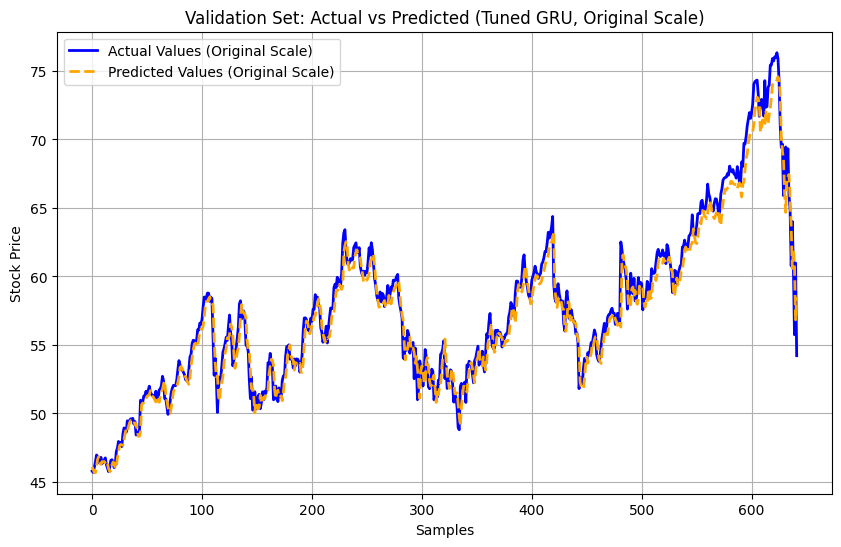

In [ ]:
y_val_pred_tuned_gru = gru_hypertuned.model.predict(X_val)

y_val_reshaped = y_val.reshape(-1, 1)  
y_val_pred_tuned_gru_reshaped = y_val_pred_tuned_gru.reshape(-1, 1)

# Perform inverse transformation on just the Close column
y_val_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_val_reshaped)] * (train_data.shape[1] - 1) + [y_val_reshaped])
)[:, -1]
y_val_pred_tuned_gru_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_val_pred_tuned_gru_reshaped)] * (train_data.shape[1] - 1) + [y_val_pred_tuned_gru_reshaped])
)[:, -1]

mae = mean_absolute_error(y_val_inv, y_val_pred_tuned_gru_inv)
mse = mean_squared_error(y_val_inv, y_val_pred_tuned_gru_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_inv, y_val_pred_tuned_gru_inv)

# Print metrics
print(f"Tuned GRU Validation Metrics (Original Scale):")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

# Plot Predicted vs Actual Values (Original Scale)
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv, label='Actual Values (Original Scale)', color='blue', linewidth=2)
plt.plot(y_val_pred_tuned_gru_inv, label='Predicted Values (Original Scale)', color='orange', linewidth=2, linestyle='dashed')
plt.title('Validation Set: Actual vs Predicted (Tuned GRU, Original Scale)')
plt.xlabel('Samples')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()


### Evaluating on the test dataset

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Tuned RNN Test Metrics (Original Scale):
Mean Absolute Error (MAE): 32.46497428157248
Mean Squared Error (MSE): 1428.1534789570057
Root Mean Squared Error (RMSE): 37.790917942767756
R-squared (R2): -1.5241102247961118


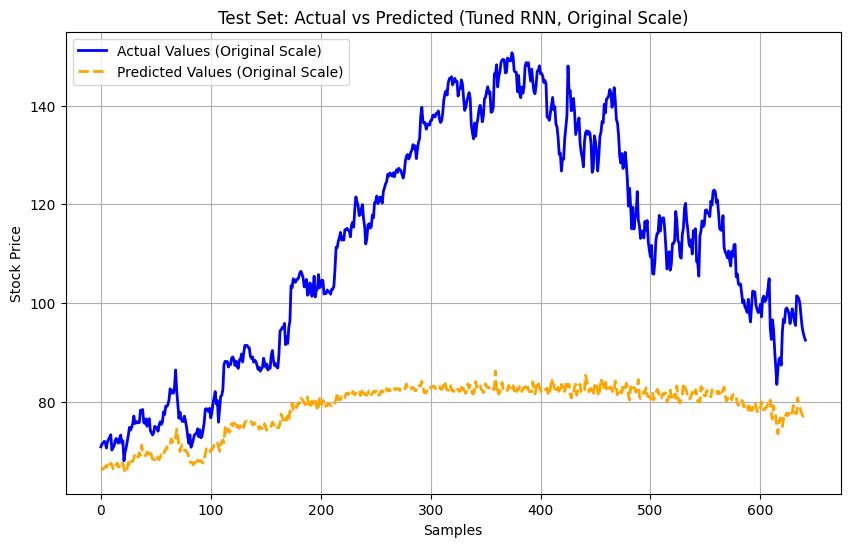

In [ ]:
y_test_reshaped = y_test.reshape(-1, 1)  
y_test_pred_tuned_rnn = vanilla_rnn_hypertuned.model.predict(X_test).reshape(-1, 1)

# Perform inverse transformation on just the Close column
y_test_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_test_reshaped)] * (train_data.shape[1] - 1) + [y_test_reshaped])
)[:, -1]
y_test_pred_tuned_rnn_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_test_pred_tuned_rnn)] * (train_data.shape[1] - 1) + [y_test_pred_tuned_rnn])
)[:, -1]

mae_test = mean_absolute_error(y_test_inv, y_test_pred_tuned_rnn_inv)
mse_test = mean_squared_error(y_test_inv, y_test_pred_tuned_rnn_inv)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_inv, y_test_pred_tuned_rnn_inv)

# Print test metrics
print(f"Tuned RNN Test Metrics (Original Scale):")
print(f"Mean Absolute Error (MAE): {mae_test}")
print(f"Mean Squared Error (MSE): {mse_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_test}")
print(f"R-squared (R2): {r2_test}")

# Plot Predicted vs Actual Values (Test Data, Original Scale)
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual Values (Original Scale)', color='blue', linewidth=2)
plt.plot(y_test_pred_tuned_rnn_inv, label='Predicted Values (Original Scale)', color='orange', linewidth=2, linestyle='dashed')
plt.title('Test Set: Actual vs Predicted (Tuned RNN, Original Scale)')
plt.xlabel('Samples')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Tuned LSTM Test Metrics (Original Scale):
Mean Absolute Error (MAE): 7.428621096031688
Mean Squared Error (MSE): 87.47836638225867
Root Mean Squared Error (RMSE): 9.352987029941755
R-squared (R2): 0.8453912396060012


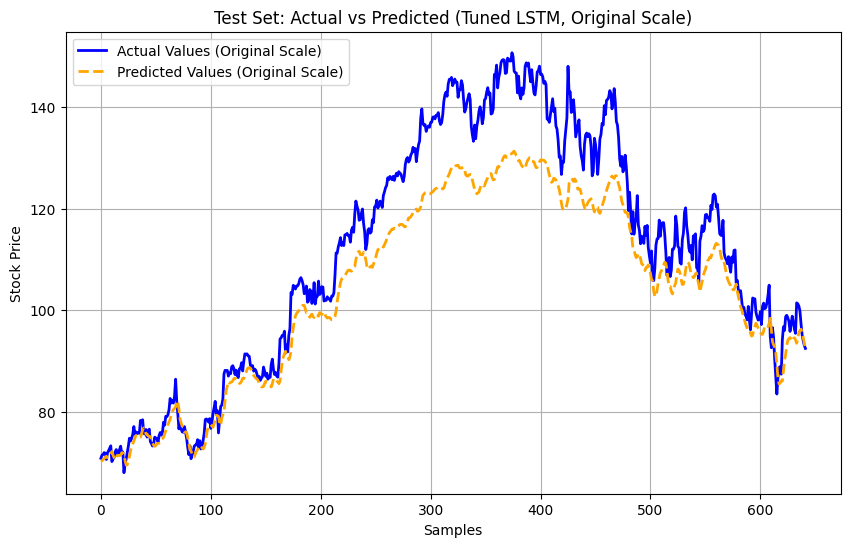

In [ ]:
y_test_reshaped = y_test.reshape(-1, 1) 
y_test_pred_tuned_lstm = lstm_hypertuned.model.predict(X_test).reshape(-1, 1)

# Perform inverse transformation on just the Close column
y_test_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_test_reshaped)] * (train_data.shape[1] - 1) + [y_test_reshaped])
)[:, -1]
y_test_pred_tuned_lstm_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_test_pred_tuned_lstm)] * (train_data.shape[1] - 1) + [y_test_pred_tuned_lstm])
)[:, -1]

mae_test = mean_absolute_error(y_test_inv, y_test_pred_tuned_lstm_inv)
mse_test = mean_squared_error(y_test_inv, y_test_pred_tuned_lstm_inv)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_inv, y_test_pred_tuned_lstm_inv)

# Print test metrics
print(f"Tuned LSTM Test Metrics (Original Scale):")
print(f"Mean Absolute Error (MAE): {mae_test}")
print(f"Mean Squared Error (MSE): {mse_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_test}")
print(f"R-squared (R2): {r2_test}")

# Plot Predicted vs Actual Values (Test Data, Original Scale)
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual Values (Original Scale)', color='blue', linewidth=2)
plt.plot(y_test_pred_tuned_lstm_inv, label='Predicted Values (Original Scale)', color='orange', linewidth=2, linestyle='dashed')
plt.title('Test Set: Actual vs Predicted (Tuned LSTM, Original Scale)')
plt.xlabel('Samples')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Tuned GRU Test Metrics (Original Scale):
Mean Absolute Error (MAE): 9.063424071790273
Mean Squared Error (MSE): 119.28523295317137
Root Mean Squared Error (RMSE): 10.921777920886845
R-squared (R2): 0.78917596700869


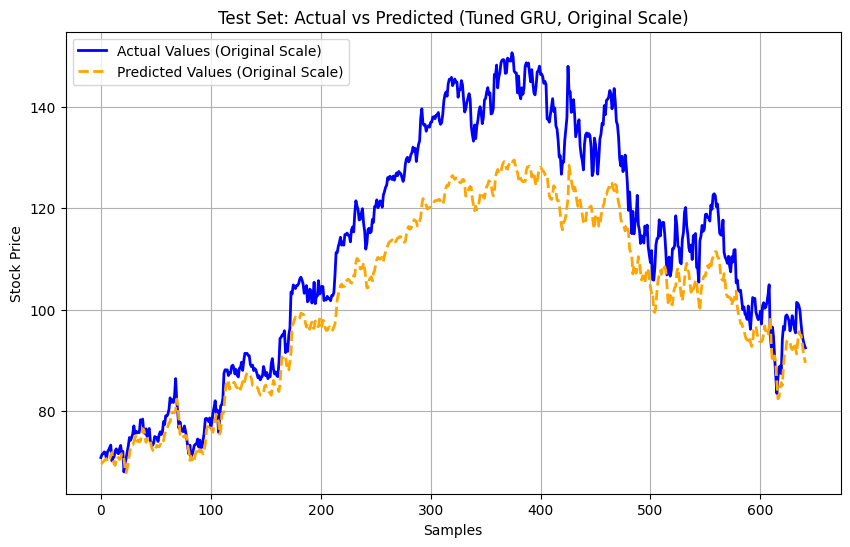

In [ ]:
y_test_reshaped = y_test.reshape(-1, 1)  
y_test_pred_tuned_gru = gru_hypertuned.model.predict(X_test).reshape(-1, 1)

# Perform inverse transformation on just the Close column
y_test_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_test_reshaped)] * (train_data.shape[1] - 1) + [y_test_reshaped])
)[:, -1]
y_test_pred_tuned_gru_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_test_pred_tuned_gru)] * (train_data.shape[1] - 1) + [y_test_pred_tuned_gru])
)[:, -1]

mae_test = mean_absolute_error(y_test_inv, y_test_pred_tuned_gru_inv)
mse_test = mean_squared_error(y_test_inv, y_test_pred_tuned_gru_inv)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_inv, y_test_pred_tuned_gru_inv)

# Print test metrics
print(f"Tuned GRU Test Metrics (Original Scale):")
print(f"Mean Absolute Error (MAE): {mae_test}")
print(f"Mean Squared Error (MSE): {mse_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_test}")
print(f"R-squared (R2): {r2_test}")

# Plot Predicted vs Actual Values (Test Data, Original Scale)
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual Values (Original Scale)', color='blue', linewidth=2)
plt.plot(y_test_pred_tuned_gru_inv, label='Predicted Values (Original Scale)', color='orange', linewidth=2, linestyle='dashed')
plt.title('Test Set: Actual vs Predicted (Tuned GRU, Original Scale)')
plt.xlabel('Samples')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
     Actual Close (Original Scale)  Predicted Close (Original Scale) Signal
632                      95.440002                         92.303886   Sell
633                     101.449997                         91.279442   Sell
634                     101.279999                         93.693916   Hold
635                     100.830002                         95.689796   Hold
636                      99.870003                         95.084190   Hold
637                      97.309998                         94.993683   Hold
638                      95.150002                         93.698395   Sell
639                      93.949997                         91.701149   Sell
640                      93.070000                         90.516617   Sell
641                      92.474998                         89.506088   Sell


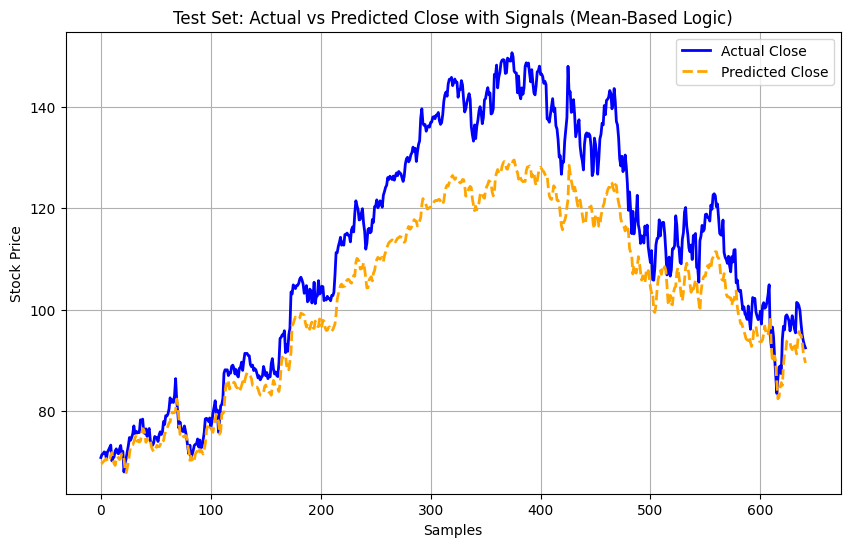

In [ ]:
y_test_pred = gru_hypertuned.model.predict(X_test)

y_test_reshaped = y_test.reshape(-1, 1) 
y_test_pred_reshaped = y_test_pred.reshape(-1, 1)

# Perform inverse transformation on just the Close column
y_test_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_test_reshaped)] * (train_data.shape[1] - 1) + [y_test_reshaped])
)[:, -1]
y_test_pred_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_test_pred_reshaped)] * (train_data.shape[1] - 1) + [y_test_pred_reshaped])
)[:, -1]

# Generate signals using the mean of the past 50 days' actual prices
signals = []
for i in range(len(y_test_inv) - 50):  
    past_10_mean = np.mean(y_test_inv[i:i+10])  
    predicted_price = y_test_pred_inv[i+10]  

    # Calculate percentage change
    percentage_change = ((predicted_price - past_10_mean) / past_10_mean) * 100

    # Generate the signal based on the percentage change
    if percentage_change > 5:
        signals.append("Buy")
    elif percentage_change < -5:
        signals.append("Sell")
    else:
        signals.append("Hold")

# Add NaN for the first 50 days where the signal cannot be computed
signals = [None] * 50 + signals

# Combine into a DataFrame for output
results = pd.DataFrame({
    'Actual Close (Original Scale)': y_test_inv,
    'Predicted Close (Original Scale)': y_test_pred_inv,
    'Signal': signals
})


pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False) 
pd.set_option('display.max_rows', None)  
print(results.tail(10))

# Visualize the predicted vs actual closing prices with signals
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual Close', color='blue', linewidth=2)
plt.plot(y_test_pred_inv, label='Predicted Close', color='orange', linestyle='dashed', linewidth=2)
plt.title('Test Set: Actual vs Predicted Close with Signals (Mean-Based Logic)')
plt.xlabel('Samples')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()


### Graph of Stock Price Distribution

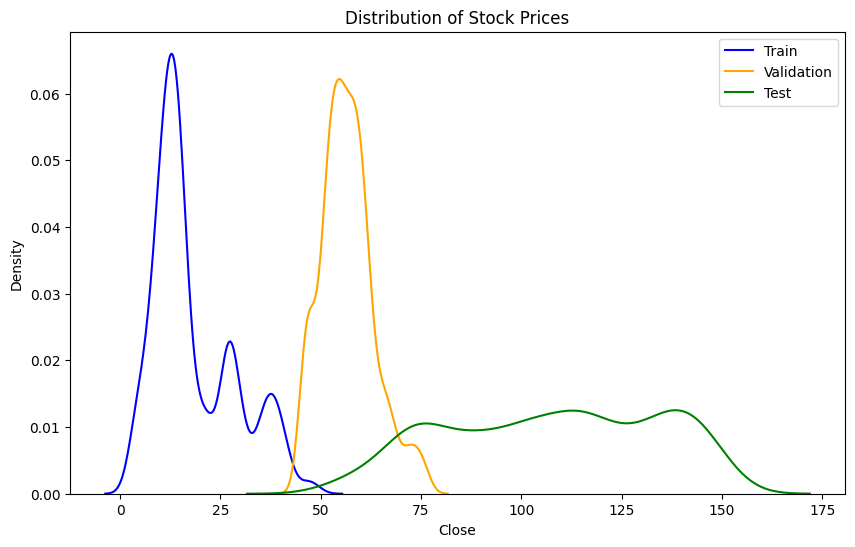

In [33]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(train_data['Close'], label='Train', color='blue')
sns.kdeplot(validation_data['Close'], label='Validation', color='orange')
sns.kdeplot(test_data['Close'], label='Test', color='green')
plt.title('Distribution of Stock Prices')
plt.legend()
plt.show()
